In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb

In [3]:
sub_list = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
data_dir = f'/lab_data/behrmannlab/vlad/pepdoc/results_ex1' #read in the file; first value is the file name
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD
results_dir = f'{curr_dir}/results' #where to save the results

# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data



pre_stim = 50 #ms before stim onset
stim_end = 300 #ms when stim goes off
post_stim = 500 #ms after stim offset
bin_length = 4 #length of each bin in ms
bin_size = 1 #how many bins were averaged over; 1 = no averaging; 5 = average over 20 ms

#calculate start window for analysis given the bin size and length
start_window = pre_stim - (bin_length*(bin_size-1)) 
#calculate the onset point of the stimulus in the dataframe given the start window and bin length
stim_onset = int(start_window/bin_length)+1 
stim_offset = int(stim_end/bin_length)+stim_onset-1
timepoints = list(range(-start_window, post_stim, bin_length)) #134 20 ms bins


#### Main decoding plots

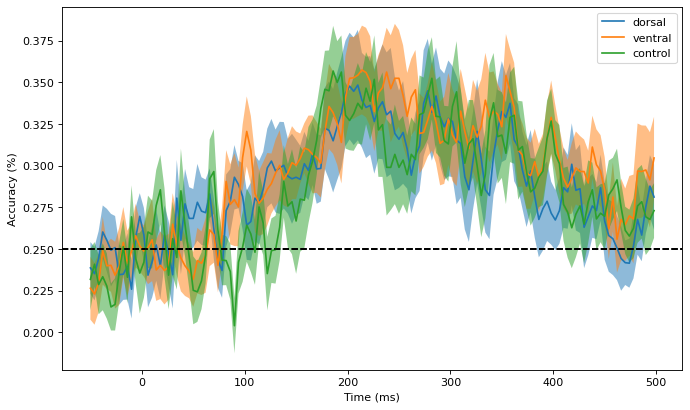

In [104]:
'''
Plot decodeing accuracy for each ROI with shading
'''
rois = ['dorsal','ventral','control']
#rois = ['dorsal']

plt.figure(figsize=(10, 6), dpi=80)
for roi in rois:
    roi_decoding = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5)
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Accuracy (%)')
    
    



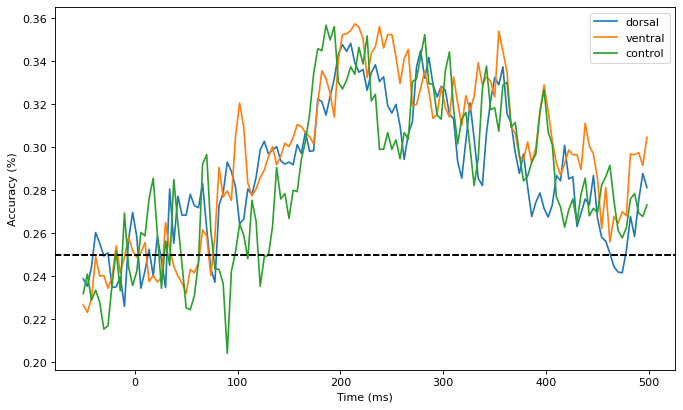

In [105]:
'''
Plot decodeing accuracy for each ROI without shading
'''

rois = ['dorsal','ventral','control']
#rois = ['dorsal']

plt.figure(figsize=(10, 6), dpi=80)
for roi in rois:
    roi_decoding = np.load(f'{results_dir}/{roi}_decoding.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Accuracy (%)')

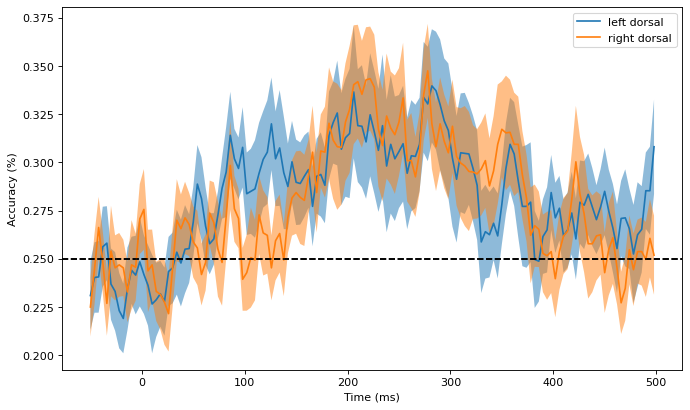

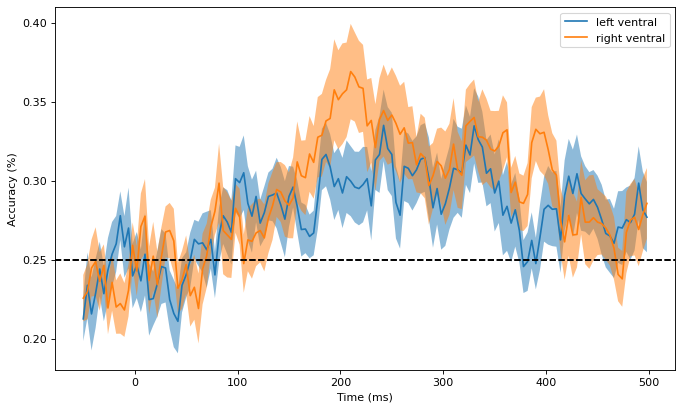

In [106]:
'''
Plot decoding accuracy split by hemi
''' 
rois = ['dorsal','ventral']

for roi in rois:
    plt.figure(figsize=(10, 6), dpi=80)
    for lr in ['left','right']:
        roi_decoding = np.load(f'{results_dir}/decode/{lr}_{roi}_decoding.npy')
        roi_mean = np.mean(roi_decoding, axis=0)
        
        sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

        plt.plot(timepoints, roi_mean, label=f'{lr} {roi}') #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
        plt.axhline(y=0.25, color='k', linestyle='--')
        #plt.axhline(y=0.2215, color='k', linestyle='--')
        plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5)
        plt.legend()

        plt.xlabel('Time (ms)')
        plt.ylabel('Accuracy (%)')
    plt.show()

#### Significance across time

In [107]:
#dorsal
rois = ['dorsal','ventral','control']
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    sig_ts = []
    for time in range(0, decoding_data.shape[1]):
        p_val = stats.ttest_1samp((decoding_data[:,time]), .25, axis = 0, alternative='greater')
        sig_ts.append(p_val[1])

    np.save(f'{results_dir}/decode/{roi}_sig_ts.npy', sig_ts)

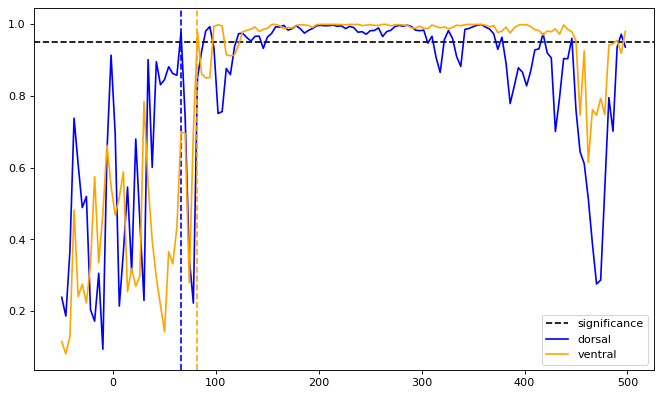

In [108]:
'''
Plot significance time series
'''

rois = ['dorsal','ventral']
line_color = ['b','orange','green']
alpha_level = .95
plt.figure(figsize=(10, 6), dpi=80)
plt.axhline(alpha_level, color = 'k', label='significance', linestyle='--')
for roi in enumerate(rois):
    sig_data = 1-np.load(f'{results_dir}/decode/{roi[1]}_sig_ts.npy')
    onset = np.min(np.where(sig_data >= alpha_level))
    onset = (onset *bin_length)-start_window
    plt.plot(timepoints, sig_data, label = roi[1], color = line_color[roi[0]])
    plt.axvline(onset,  linestyle='--', color = line_color[roi[0]])
    plt.legend()





#### Test significant onset

In [109]:
'''
Calculate onsets for each subject
''' 
alpha_level = .95
rois = ['dorsal','ventral','control']
sub_df = pd.DataFrame()
for roi in rois:
    decoding_sig = np.load(f'{results_dir}/decode/{roi}_decoding_sig.npy')
    decoding_sig = decoding_sig[:,stim_onset:]
    roi_onset = []
    for sub in range(0, decoding_sig.shape[0]):
        sig_times = np.where(decoding_sig[sub,:] <= 1-alpha_level)[0]

        for st in range(0, len(sig_times)):
            if st >0:
                if sig_times[st] - sig_times[st-1] == 1:
                    onset = sig_times[st-1]
                    break

        onset = (onset *bin_length)+4
        roi_onset.append(onset) 
    
    sub_df[roi] = roi_onset
    sub_df.to_csv(f'{results_dir}/onsets/{roi}_sub_onsets.csv')

In [110]:
'''
Run binomial test on subjects
'''

comparisons = [['dorsal','ventral'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = sub_df[roi[0]] - sub_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print(stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    



0.5034446716308594


In [111]:
'''
Boot strap participant data and extract onset
'''

rois = ['dorsal','ventral']
iter = 1000

boot_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/{roi}_decoding.npy')
    decoding_data = decoding_data[:,stim_onset:]
    decoding_data = pd.DataFrame(decoding_data) #convert to dataframe because it has a good resampling function
    decode_boot = []
    sub_counts = np.zeros((1,decoding_data.shape[1]))

    for ii in range(0,iter):
        
        #resample the sub decode data with replacement
        sub_sample = decoding_data.sample(decoding_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 
        
        #calculate the bootstrap sample mean
        sig_boot = []
        
        #only add values if they are significant two timepoints in arow
        sig_consistent = []
        
        sig_ts = []
        for time in range(0,sub_sample.shape[1]):
            p_val= stats.ttest_1samp(sub_sample[:,time], .25, axis = 0, alternative='greater')
            
            #append the p-value for every time point
            sig_ts.append(p_val[1])  


            #mark timepoints that are above chance for at least two timepoints in a row
            if time > 0:

                if sig_ts[time] <= .05 and sig_ts[time-1] <=.05:
                    sig_consistent.append(1)
                else:
                    sig_consistent.append(0)

        #reconvert p-value list into a numpy array
        sig_ts = np.asanyarray(sig_ts)

        #reconvert consistent list into a numpy array
        sig_consistent = np.asanyarray(sig_consistent)
            
        #find the the first time point that is below change (0.05)
        #np.where simply returns the indices (i.e., spots in an array), that meet some condition
        #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
        try:
            sig_onset = np.where(sig_consistent ==1,)[0][0]
        except:
            sig_onset= decoding_data.shape[1]
        
        
        
        sub_counts[0,np.where(sig_ts <=.05)[0]] += 1
        
        #if d_onset == 1:
        #    pdb.set_trace()
        
        #convert to the actual time point
        sig_onset = (sig_onset *4)-36

        #add the onset value from the resample to a list
        decode_boot.append(sig_onset)
    
    boot_df[roi] = decode_boot

boot_df.to_csv(f'{results_dir}/onsets/onset_boot_df.csv')

In [112]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print(stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    



5.249291116750507e-27


In [114]:
print(time_count)

669


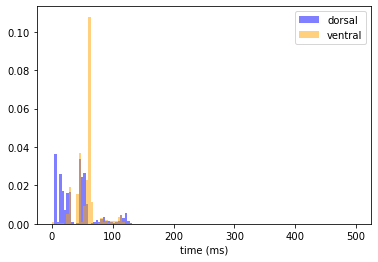

In [113]:
plt.hist(boot_df['dorsal'], range = [0, 500], label='dorsal', color='b', alpha=.5, bins= 125, density=True)
plt.hist(boot_df['ventral'],range = [0, 500], label='ventral', color='orange', alpha=.5, bins= 125, density=True)
#plt.hist(c_boot,range = [0, 150], label='control', color='g', alpha=.5, bins= 150, density=True)



plt.xlabel('time (ms)')
plt.legend(loc='upper right')

In [114]:
#plot the difference values with confidence intervals
alpha = .05
ci_low = np.percentile(diff, alpha*100)
ci_high= np.percentile(diff, 100-alpha*100)
print(ci_low,ci_high)

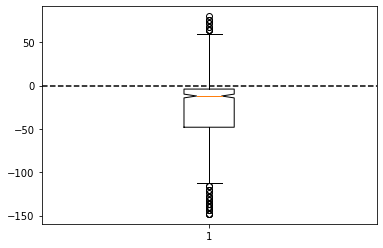

In [118]:
plt.boxplot(diff,notch=True)
plt.axhline(0, color = 'k', label='significant', linestyle='--')

#### Calculate summary stats

In [43]:
'''
AUC for each subject
'''

rois = ['dorsal','ventral','control', 'left_dorsal', 'right_dorsal', 'left_ventral', 'right_ventral']

sub_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/{roi}_decoding.npy')
    decoding_data = decoding_data[:,stim_onset:]
    roi_data=[]
    for sub_n in range(0, decoding_data.shape[0]):
        
        roi_data.append(metrics.auc(np.arange(0,decoding_data.shape[1]), decoding_data[sub_n,:]))

    sub_df[roi] = roi_data





Text(0, 0.5, 'AUC')

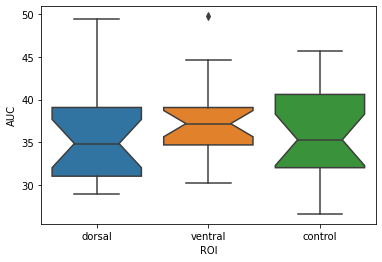

In [51]:
sns.boxplot(data=sub_df[['dorsal','ventral','control']], notch= True)
plt.xlabel('ROI')
plt.ylabel('AUC')

#### Granger causality

In [3]:
'''
Univariate GCA
'''

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 10

comparisons = [['dorsal','ventral']]
for roi in comparisons:
    roi_fs = []
    for sub in sub_list:
        roi_df = pd.DataFrame()
        roi_data1 = np.load(f'{data_dir}/{sub}_{roi[0]}_concat_ts.npy')
        roi_data2 = np.load(f'{data_dir}/{sub}_{roi[1]}_concat_ts.npy')

        roi_df[roi[0]] = np.mean(roi_data1, axis = 1)
        roi_df[roi[1]] = np.mean(roi_data2, axis = 1)

        roi_df = roi_df.apply(stats.zscore)


        #df = df.diff().dropna()

        gc_1 = grangercausalitytests(roi_df[[roi[0],roi[1]]], maxlag=max_lag)
        gc_2 = grangercausalitytests(roi_df[[roi[1],roi[0]]], maxlag=max_lag)

        roi1_f = []
        roi2_f = []
        for gcn in range(1,len(gc_1)):
            roi1_f.append(gc_1[gcn][0]['ssr_ftest'][0])
            roi2_f.append(gc_2[gcn][0]['ssr_ftest'][0])

        max_roi_1 = np.max(roi1_f)
        max_roi_2 = np.max(roi2_f)

        roi_fs.append(max_roi_1 - max_roi_2)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9510 , p=0.0010  , df_denom=1496, df_num=1
ssr based chi2 test:   chi2=10.9730 , p=0.0009  , df=1
likelihood ratio test: chi2=10.9330 , p=0.0009  , df=1
parameter F test:         F=10.9510 , p=0.0010  , df_denom=1496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.0283 , p=0.0000  , df_denom=1493, df_num=2
ssr based chi2 test:   chi2=24.1372 , p=0.0000  , df=2
likelihood ratio test: chi2=23.9448 , p=0.0000  , df=2
parameter F test:         F=12.0283 , p=0.0000  , df_denom=1493, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.3968  , p=0.0000  , df_denom=1490, df_num=3
ssr based chi2 test:   chi2=25.3087 , p=0.0000  , df=3
likelihood ratio test: chi2=25.0971 , p=0.0000  , df=3
parameter F test:         F=8.3968  , p=0.0000  , df_denom=1490, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3184  , p=0.

#### Time generalized RSA analyses

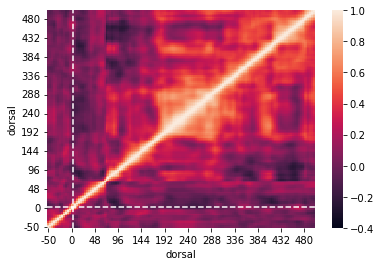

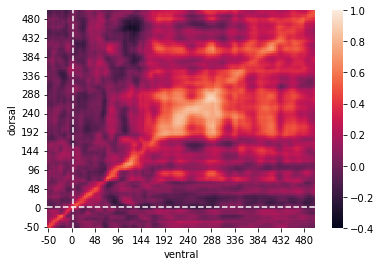

In [4]:
"""
Plot time generalization RDMs
"""

rois = ['dorsal','ventral']
#rois = ['dorsal']

#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
for roi1 in rois:
    for roi2 in rois:
        corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
        corr_df = pd.DataFrame(corr_ts, columns = time_cols, index = time_cols)

        ax = sns.heatmap(corr_df,xticklabels=12,yticklabels=12, vmin = -.4, vmax = 1)
        #ax.set_title(f'{roi1} {roi2}')
        ax.invert_yaxis()
        plt.axvline(13,  linestyle='--', color = 'white')
        plt.axhline(13,  linestyle='--', color = 'white')
        plt.ylabel(roi1)
        plt.xlabel(roi2)
        plt.show()
        
    break

In [10]:
np.max

In [12]:
np.where(test == np.max(test))

(array([82]), array([84]))

In [93]:
"""
Test whether RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral','control']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
df = pd.DataFrame()
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
            corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

            #extract left and right sides of the diagnol
            left_side = corr_ts[np.triu_indices(n=corr_ts.shape[0],k=1)] #extract upper triangle
            right_side = corr_ts[np.tril_indices(n=corr_ts.shape[0],k=-1)] #extract lower triangle

            #calculate the difference between the left and right sides
            #if positive, then right shifted
            diff = right_side - left_side


            df[f'{roi1}_{roi2}'] = diff
            #left side rdm




Text(0, 0.5, 'Time Diff')

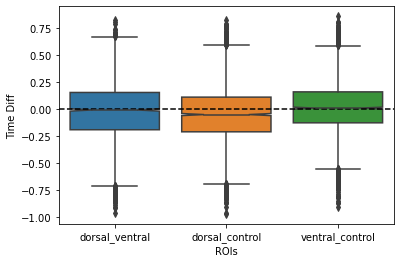

In [99]:
sns.boxplot(data = df[['dorsal_ventral','dorsal_control','ventral_control']],notch=True)
plt.axhline(0, color = 'k', label='significant', linestyle='--')
plt.xlabel('ROIs')
plt.ylabel('Time Diff')

In [100]:
df.mean()

dorsal_ventral    -0.014963
dorsal_control    -0.040094
ventral_dorsal     0.014963
ventral_control    0.016712
control_dorsal     0.040094
control_ventral   -0.016712
dtype: float64

In [72]:
(74*73)/2

2701.0